##  Title : Sentiment Analysis of Spotify Customer Reviews Using LSTM and NLP
                                                                                                                                                                                                                        @Shalini Sah

# Imports

In [5]:
from keras_preprocessing.text import tokenizer_from_json
from transformers import AutoTokenizer
import keras_preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')  # Change model name as needed
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import warnings as wr
from tensorflow.keras.layers import Dense,Embedding,LSTM,GRU,Bidirectional,Dropout
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.metrics import Precision,F1Score,Recall
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shalini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/shalini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/shalini/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Dataset Preparation 
#1.Taken the data from Kaggle: https://www.kaggle.com/datasets/alexandrakim2201/spotify-dataset

#2.Rows:  52,702.  This contains user reviews for the Spotify.
  Columns :2. Text Contains reviews of application and label "POSITIVE" or "NEGATIVE" based on its sentiment.


In [7]:
# Read the data dowloaded from Kaggle 
df = pd.read_csv('Spotify.csv')

In [8]:
# Shape of dataframe
df.shape 

(52702, 2)

In [9]:
# dataframe df
df.head()

,Review,label
0,"Great music service, the audio is high quality...",POSITIVE
1,Please ignore previous negative rating. This a...,POSITIVE
2,"This pop-up ""Get the best Spotify experience o...",NEGATIVE
3,Really buggy and terrible to use as of recently,NEGATIVE
4,Dear Spotify why do I get songs that I didn't ...,NEGATIVE


In [10]:
# Let's check for missing values/NAN values
df.isnull().sum()

Review    16
label      0
dtype: int64

Text contain 16 null values, we are dropping it as it doesn't make much difference on the dataset

In [11]:
# Dropping the Null and checking the shape of df dataframe
df= df.dropna()
df.shape

(52686, 2)

In [8]:
# Count the occurrences of each sentiment category
sentiment_counts = df['label'].value_counts()

# Print the counts
print(sentiment_counts)

label
NEGATIVE    29423
POSITIVE    23263
Name: count, dtype: int64


The data is balanced.
NEGATIVE: 29423 of the total reviews
POSITIVE: 23263% of the total reviews

In [9]:
# Checking the full review
df["Review"][4]


"Dear Spotify why do I get songs that I didn't put on my playlist??? And why do we have shuffle play?"

In [10]:
# Review is Negative
print(df.loc[4])

Review    Dear Spotify why do I get songs that I didn't ...
label                                              NEGATIVE
Name: 4, dtype: object


# 2. Data Preprocessing

In [13]:
# Updated clean_text function with lemmatization
def clean_text(text):
    text = re.sub(r"http\S+", "", text)         # Remove URLs
    #text = re.sub(r"[^a-zA-Z\s]", "", text)    # Remove special characters
    text = text.lower()                         # Convert to lowercase
    tokens = re.split('\W+', text)              # Split text into tokens
    lemmatized_text = [wn.lemmatize(word) for word in tokens]  # Apply lemmatization
    
    return ' '.join(lemmatized_text)            # Return cleaned string

# Get cleaned text
df['text_cleaned'] = df['Review'].apply(lambda x: clean_text(x))

# Display the first5rows
print(df.head())





                                              Review     label  \
0  Great music service, the audio is high quality...  POSITIVE   
1  Please ignore previous negative rating. This a...  POSITIVE   
2  This pop-up "Get the best Spotify experience o...  NEGATIVE   
3    Really buggy and terrible to use as of recently  NEGATIVE   
4  Dear Spotify why do I get songs that I didn't ...  NEGATIVE   

                                        text_cleaned  
0  great music service the audio is high quality ...  
1  please ignore previous negative rating this ap...  
2  this pop up get the best spotify experience on...  
3     really buggy and terrible to use a of recently  
4  dear spotify why do i get song that i didn t p...  


Data is cleaned by removing URLS, special characters, lowercasing, lemmatization and splitting the words into tokens.

# 3. Data Visualization

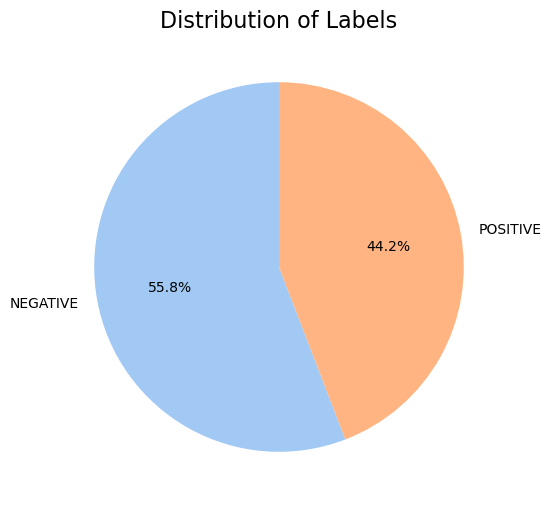

In [16]:
# Plot of positive and Negative Count
# Count the occurrences of each label
label_counts = df['label'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 6)) 
plt.pie(
    label_counts, 
    labels=label_counts.index, 
    autopct='%1.1f%%',  
    startangle=90,  
    colors=sns.color_palette("pastel")
)
plt.title("Distribution of Labels", fontsize=16) 
plt.show()

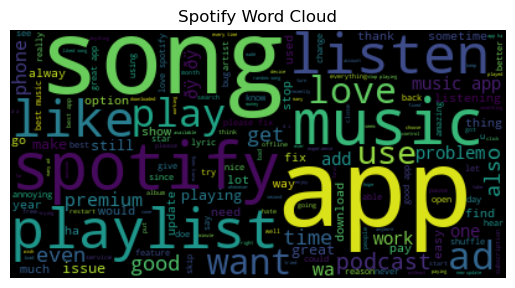

In [14]:
# Fetch stopwords from NLTK and convert to a set
stopword = set(stopwords.words('english'))  

# Function to generate word cloud
def generate_wordcloud(data, title):
    text = " ".join(data) 
    wordcloud = WordCloud(stopwords=stopword, background_color='black', max_words=250).generate(text)
    
    # Display the word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")  


generate_wordcloud(df['text_cleaned'], 'Spotify Word Cloud')

 Top 50 Most Frequent Words in Positive Reviews


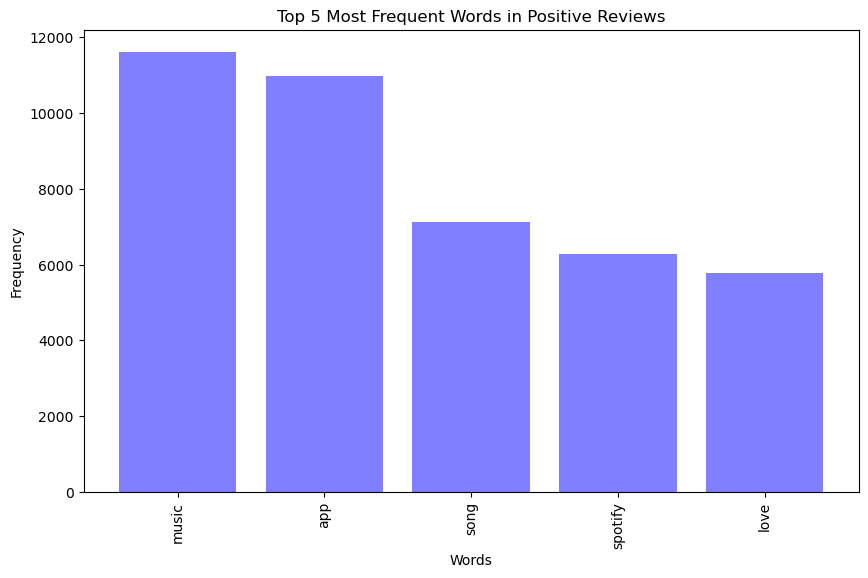

In [15]:
# Filter for positive reviews 
positive_reviews = df[df['label'] == 'POSITIVE']['text_cleaned']

# Define stopwords list (you can customize this if needed)
stop_words = set(stopwords.words('english'))

# Tokenize the positive reviews text
positive_words = word_tokenize(' '.join(positive_reviews))

# Filter out non-alphabetical words and stopwords
positive_words = [word.lower() for word in positive_words if word.isalpha() and word.lower() not in stop_words]

# Calculate the frequency distribution of words
freq_dist = FreqDist(positive_words)

# Select the top 10 most frequent words
top_words = freq_dist.most_common(5)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_words)), [freq for word, freq in top_words], align='center', alpha=0.5, color='blue')
plt.xticks(range(len(top_words)), [word for word, freq in top_words], rotation='vertical')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 5 Most Frequent Words in Positive Reviews')
plt.show()



The most common words in the text are music, app, song,spotify,love.

# 4. LSTM Model Development 


In [19]:
# Encoding label into 1 and 0/ Test data
y = df['label']
y = np.array(list(map(lambda x: 1 if x=="POSITIVE" else 0, y)))

In [20]:
# Train data as text_cleaned
X = df['text_cleaned']

In [22]:
# Training the model using a train/test split of 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [23]:
# Create and fit the Tokenizer object on training 
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

In [24]:
# Convert the training and test data into sequences
X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [25]:
import io
import json
import os
# Saving
# output directory name:
output_dir = 'model_output/LSTM'
os.makedirs(output_dir, exist_ok=True)

tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [26]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

18403

In [28]:
# Padding all reviews to fixed length 100
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Word Embeddings
Glove embedding is used which is dowloaded from Kaggle: https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation
 glove.6B.100d.txt for word Embedding

In [32]:
# Load GloVe word embeddings and create an Embeddings Dictionary
from numpy import asarray

# Initialize the embeddings dictionary
embeddings_dictionary = dict()

# Open the GloVe file and load the embeddings
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')  # Corrected the variable name
    embeddings_dictionary[word] = vector_dimensions  # Save the word and its corresponding vector

glove_file.close()


In [33]:
# Create Embedding Matrix having 100 columns 
# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((vocab_length, 100))

# Populate the embedding matrix with GloVe word vectors
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        # If the word is in the GloVe embeddings dictionary, set the corresponding row in the embedding matrix
        embedding_matrix[index] = embedding_vector

In [34]:
embedding_matrix.shape

(18403, 100)

# Design LSTM neural network model

In [38]:
# Neural Network architecture
from keras.layers import LSTM
model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_shape=(100,), trainable=False)

model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))

In [39]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary to verify the structure
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │     1,840,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,957,677 (7.47 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 1,840,300 (7.02 MB)

None


In [40]:
# Model training

lstm_model_history = model.fit(X_train, y_train, batch_size=128, epochs= 10, verbose=1, validation_split=0.2)

Epoch 1/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 23s 86ms/step - accuracy: 0.6600 - loss: 0.6163 - val_accuracy: 0.6069 - val_loss: 0.6469
Epoch 2/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.6574 - loss: 0.5966 - val_accuracy: 0.8403 - val_loss: 0.3836
Epoch 3/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - accuracy: 0.8634 - loss: 0.3263 - val_accuracy: 0.8801 - val_loss: 0.3007
Epoch 4/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.8815 - loss: 0.2902 - val_accuracy: 0.8804 - val_loss: 0.2955
Epoch 5/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - accuracy: 0.8927 - loss: 0.2723 - val_accuracy: 0.8864 - val_loss: 0.2830
Epoch 6/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - accuracy: 0.9004 - loss: 0.2525 - val_accuracy: 0.8922 - val_loss: 0.2661
Epoch 7/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.9007 - loss: 0.2494 - val_accuracy: 0.8953 - val_loss: 0.2573
Epoch 8/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - accuracy: 0.8991 - loss: 0.2462 - 

In [41]:
# Evaluate
score = model.evaluate(X_test, y_test, verbose=1)

330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9038 - loss: 0.2471


In [42]:
from sklearn.metrics import accuracy_score

# Predict on training data and calculate training accuracy
y_pred_train = (model.predict(X_train) > 0.5).astype(int)
accuracy_train = accuracy_score(y_train, y_pred_train)

# Predict on test data and calculate test accuracy
y_pred_test = (model.predict(X_test) > 0.5).astype(int)
accuracy_test = accuracy_score(y_test, y_pred_test)

# Print accuracies
print(f"Training Accuracy: {accuracy_train:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")

1318/1318 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
Training Accuracy: 0.9136
Test Accuracy: 0.9030


In [ ]:
## Model saving so that it can be used later

In [44]:
# Saving the model as keras file
model.save(f"./model_acc_{round(score[1], 3)}.keras")


# 5. Making Predictions on Reviews which are not part of Review dataset using pretained model

In [45]:
# checking the pretrained model Path
import os
print(os.path.exists('model_acc_0.903.keras'))


True


In [54]:
# Load previously trained LSTM Model

from keras.models import load_model

model_path = 'model_acc_0.903.keras'
pretrained_model = load_model(model_path)

# summarize model.
pretrained_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │     1,840,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,192,433 (8.36 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 1,840,300 (7.02 MB)

 Optimizer params: 234,756 (917.02 KB)

In [66]:
#Example unseen reviews
from keras_preprocessing.text import tokenizer_from_json
import json
# Loading
with open('b3_tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)
 
    #Unseen reviews

    predict_review = ["The vocals are smooth, but the song is just way too short, I couldn’t get into it."]
    #predict_review = ["The vocals are smooth, and the song is good to listen."]  
  
    # Example Reviews from actual data and understanding why they are misclasified
    #predict_review = ["The interface is user-friendly, and I love how easy it is to create playlists. However, the ads in the free version are annoying and interrupt the listening experience. Premium is worth it for the uninterrupted music and offline downloads."]
    #predict_review = ["Just bring back the \"shuffle all\" albums option"]
    #predict_review = ["As a paying customer there is nothing I can say about Spotify. It is perfecto."] # Review with perfecto 
    #predict_review = ["As a paying customer there is nothing I can say about Spotify. It is perfect."]  # Review with perfect
    #predict_review=["I love it soo much and I will rate it a 4 star, the problem is that there are constant ads, and the singing option near the lyrics doesn't seem to appear for me anymore"] 
    #predict_review= ["awesome but some song i can t find"]
    
    predict_tokenized = tokenizer.texts_to_sequences(predict_review)



In [67]:
# padded seequence for review which is not seen
predict_padded = pad_sequences(predict_tokenized, padding='post', maxlen=100)



Pretrained saved model to predict the sentiments to unseen reviews.

In [68]:
#using Pretrained model to predict sentiments
predict_sentiments = pretrained_model.predict(predict_padded)
predict_sentiments

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


array([[0.04761244]], dtype=float32)

In [69]:
# Classify sentiment as Positive, Negative
if predict_sentiments[0][0] >= 0.5:
    predicted_sentiments = "POSITIVE"
else:
    predicted_sentiments = "NEGATIVE"

sample_reviews = pd.DataFrame({
    'Review Text': [predict_review],  # Review Text
    'Predicted Sentiment': [predicted_sentiments]  # Predicted sentiment category (Positive/Negative)
})

# Display the saved DataFrame
print(sample_reviews)

                                         Review Text Predicted Sentiment
0  [The vocals are smooth, but the song is just w...            NEGATIVE


# 6. Classification Report

In [70]:
from sklearn.metrics import confusion_matrix, classification_report
cr_M = classification_report(y_test,y_pred_test)
print(cr_M)

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      5864
           1       0.88      0.90      0.89      4674

    accuracy                           0.90     10538
   macro avg       0.90      0.90      0.90     10538
weighted avg       0.90      0.90      0.90     10538



#Precision: For class 0, precision is 0.92, meaning 92% of the predictions for class 0 were accurate.

#Recall : For class 1, recall is 0.90, meaning the model successfully identified 88% of all true positives.

#The overall accuracy of the model is 0.90, meaning it correctly predicted the sentiment 90% of the time.

# 7. ERROR ANALYSIS : Discussion of misclssaified examples

In [73]:
# Misclassified outputs
misclassified = [] 
count = 0
act = []
pred = []


# Iterate through reviews and labels
for x, y in zip(df['text_cleaned'], df['label']):
    xa = []
    xa.append(x)
     
   
    predict_tokenized = tokenizer.texts_to_sequences(xa)
    predict_padded = pad_sequences(predict_tokenized, padding='post', maxlen=100)
    
    # Predict the sentiment
    predict_sentiments = pretrained_model.predict(predict_padded)
    z = 'NEGATIVE'
    if predict_sentiments[0][0] >= 0.5:
        z = "POSITIVE"

  
    # Check if prediction is incorrect
    if z[0] != y[0]:
        misclassified.append(x) 
        pred.append(z)
        act.append(y)
        count+= 1
        if count > 25:
            break
        
  

misclassified_frame = pd.DataFrame({
    'Text':misclassified ,  # List of misclassified review texts
    'LSTM_Predicted Sentiment': pred,  # Corresponding predicted sentiments
    'Actual Sentiment': act  # Corresponding actual sentiments
})



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

In [60]:
# misclassified outputs
misclassified_frame

,Text,LSTM_Predicted Sentiment,Actual Sentiment
0,the only downside is they rotate song in and o...,POSITIVE,NEGATIVE
1,a a paying customer there is nothing i can say...,NEGATIVE,POSITIVE
2,just bring back the shuffle all album option ð...,NEGATIVE,POSITIVE
3,quality sound and selection but they re add ar...,NEGATIVE,POSITIVE
4,awesome but some song i can t find,NEGATIVE,POSITIVE
5,it good but when u want to play a song they gi...,NEGATIVE,POSITIVE
6,i have used this app for the last 2 year strai...,NEGATIVE,POSITIVE
7,i love ðÿ this app it ha ad but not that level...,POSITIVE,NEGATIVE
8,it s a amazing app but if it ha been an option...,NEGATIVE,POSITIVE
9,living remotely spotify is the only way to go ...,POSITIVE,NEGATIVE


# 8. Discussion Examples

In [47]:
## Example 1
print(misclassified_frame.iloc[0]['Text'])

the only downside is they rotate song in and out so one month you can listen to that great song next month maybe not 


Example 1: the only downside is they rotate song in and out so one month you can listen to that great song next month maybe not
ActualSentiment: NEGATIVE ||  Predicted Sentiment : POSITIVE

Reason:
The review says that the downside of Spotify is that songs rotate in and out. One month, you can enjoy a great song, and the next month it might not be available. 
Even though the sentiment is negative, the LSTM model predicted it as positive as its taking the words enjoy and great as positive


In [48]:
## Example 2
print(misclassified_frame.iloc[1]['Text'])

a a paying customer there is nothing i can say about spotify it is perfecto 


Example 2: a a paying customer there is nothing i can say about spotify it is perfecto 
Actual Sentiment: POSITIVE ||  Predicted Sentiment: NEGATIVE

Reason:
The LSTM model predicted "perfecto" as negative, even though it has a positive meaning in this context. The model might have confused it with the literal meaning of "perfecto" as a cigar, not recognizing its intended sentiment. Replacing it with the word "perfect" led to the correct positive prediction, showing that the model struggled with slang variation of perfect/perfecto.

In [49]:
## Example 3
print(misclassified_frame.iloc[3]['Text'])

quality sound and selection but they re add are louder than the music sometimes 


Example 3: quality sound and selection but they re add are louder than the music sometimes
Actual Sentiment: POSITIVE ||  Predicted Sentiment : NEGATIVE

Reason:he model misclassified this review due to the presence of negative words like “louder” and “but,” which might have overshadowed the overall positive sentiment about “quality sound” and “selection.”


In [57]:
## Example 4
print(misclassified_frame.iloc[15]['Text'])

it work for a little then after a while it doesn t when pressing the play button for a song a whole different song play something i ve never heard before or pressed on but it show the song i ve requested playing please fix this 


Example 4: it work for a little then after a while it doesn t when pressing the play button for a song a whole different song play something i ve never heard before or pressed on but it show the song i ve requested playing please fix this 
Actual Sentiment : POSITIVE ||  Predicted Sentiment: NEGATIVE

Reason:
"doesn’t work" suggests a complaint.Words like "fix this" can signal dissatisfaction hence predicted sentiment is NEGATIVE

In [61]:
## Example 5
print(misclassified_frame.iloc[18]['Text'])

i have trouble because i consider it a challenge to navigate without the help site otherwise i enjoy it 


Example 5: i have trouble because i consider it a challenge to navigate without the help site otherwise i enjoy it 
Actual Sentiment: NEGATIVE ||  Predicted Sentiment : POSITIVE

Reason:
The model likely focused on positive phrases like “enjoy it,” overlooking the  “trouble” and “challenge” . This highlights difficulty in detecting complaints within mixed feedback..

# 9.  RESULT & CONCLUSION¶

1. I have achieved 90.00% accuracy

2. The difference between training accuracy (0.9237) and test accuracy (0.9027) is minimal, model is performing well and has not overfitted.

3. This model could be utilized to flag up customer complaints to a dedicated support team improving customer satisfaction.

4. I have analysed and discussed 5 misclassified examples.